# Sistema de recomendación de películas
Dado un conjunto de datos de calificaciones otorgadas por usuarios a películas, realiza lo siguiente:

+ Calcula el perfil de cada película usando los géneros como atributos.
+ Emplea un umbral para definir las películas que le gustaron al usuario a partir de la calificación otorgada en escala de 5.
+ Calcula el perfil de cada usuario con los perfiles de las películas que le gustaron. 
+ Realiza una búsqueda de películas con perfil similar al del usuario usando el producto punto como función de similitud. Puedes utilizar fuerza bruta o una biblioteca del vecino más cercano aproximado.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

from collections import Counter

## Conjunto de datos MovieLens
Para ello usaremos la versión _small_ del conjunto de datos [MovieLens](https://grouplens.org/datasets/movielens/). Esta versión incluye 100,000 calificaciones y 3,600 etiquetas de 9,000 películas realizadas por 600 usarios distintos.


In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2022-10-22 15:54:03--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip.5’

ml-latest-small.zip 100%[===================>] 955.28K  4.55MB/s    in 0.2s    

2022-10-22 15:54:04 (4.55 MB/s) - ‘ml-latest-small.zip.5’ saved [978202/978202]

Archive:  ml-latest-small.zip
replace ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-latest-small/links.csv  
replace ml-latest-small/tags.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-latest-small/tags.csv  
replace ml-latest-small/ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-latest-small/ratings.csv  
replace ml-latest-small/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflati

Cargamos las calificaciones, las etiquetas y las películas, las cuales se encuentran en archivos CSV.

In [3]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
links = pd.read_csv('ml-latest-small/links.csv')

Las etiquetas son asignadas por usuarios a una película. Un usuario puede etiquetar distintas películas y una pelicula puede estar etiquetada por múltiples usuarios.  

In [4]:
tags = tags.dropna()
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


Agrupamos las etiquetas por película. 

In [5]:
movietags = tags.groupby(['movieId'])['tag'].apply(set).reset_index(name='tags')
tagcount = Counter(t for r in movietags['tags'] for t in r)
print('{0} películas tienen al menos una etiqueta asociada por usuarios'.format(tags.shape[0]))
print('Hay {0} etiquetas distintas'.format(len(tagcount.keys())))
movietags.head()

3683 películas tienen al menos una etiqueta asociada por usuarios
Hay 1589 etiquetas distintas


,movieId,tags
0,1,"{fun, pixar}"
1,2,"{fantasy, Robin Williams, magic board game, game}"
2,3,"{moldy, old}"
3,5,"{remake, pregnancy}"
4,7,{remake}


Graficamos el histograma de número de etiquetas por película.

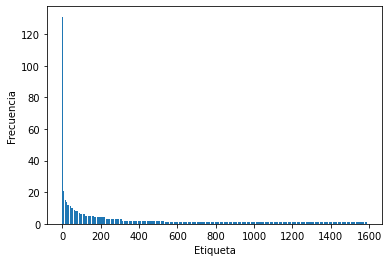

In [6]:
plt.bar(np.arange((len(tagcount.values()))), sorted(tagcount.values(), reverse=True))
plt.xlabel(u'Etiqueta')
plt.ylabel(u'Frecuencia')
plt.show()

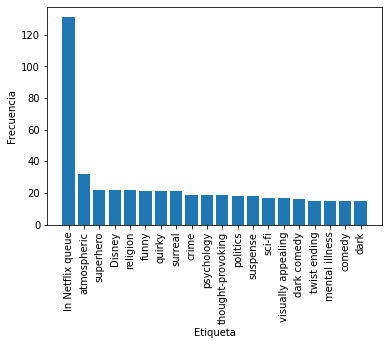

In [7]:
etiqs = [e[0] for e in tagcount.most_common(20)]
vals = [e[1] for e in tagcount.most_common(20)]
plt.bar(etiqs, vals)
plt.xticks(rotation='vertical')
plt.xlabel(u'Etiqueta')
plt.ylabel(u'Frecuencia')
plt.show()

Exploramos las calificaciones y visualizamos sus histogramas.

In [8]:
ratings = ratings.dropna()
print('{0} calificaciones de usuarios a películas'.format(ratings.shape[0]))
ratings.head()

100836 calificaciones de usuarios a películas


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


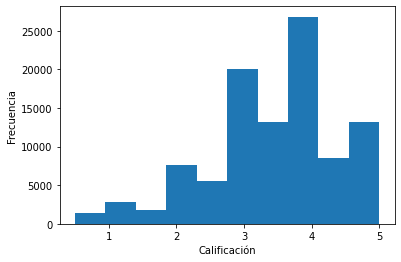

In [9]:
plt.hist(ratings['rating'])
plt.xlabel(u'Calificación')
plt.ylabel(u'Frecuencia')
plt.show()

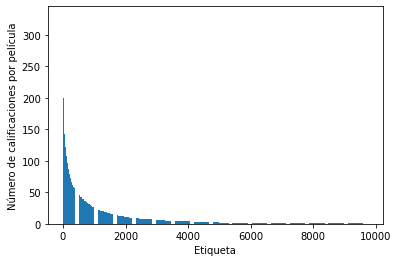

In [10]:
rvals = ratings.groupby(['movieId'])['rating'].size()
plt.bar(np.arange((len(rvals))), sorted(rvals, reverse=True))
plt.xlabel(u'Etiqueta')
plt.ylabel(u'Número de calificaciones por película')
plt.show()

Eliminamos valores faltantes de la tabla de películas, así como las películas sin género asignado (`(no genres listed)`).

In [11]:
movies = movies.dropna()
movies = movies[movies['genres']!='(no genres listed)']
print('{0} películas total'.format(movies.shape[0]))
movies.head()

9708 películas total


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Visualizamos los histogramas de géneros.

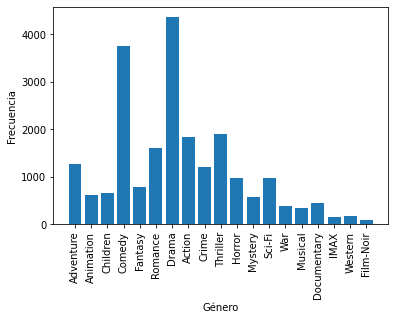

In [12]:
gcount = Counter(g for r in movies['genres'] for g in r.split('|'))
plt.bar(gcount.keys(), gcount.values())
plt.xticks(rotation='vertical')
plt.xlabel(u'Género')
plt.ylabel(u'Frecuencia')
plt.show()

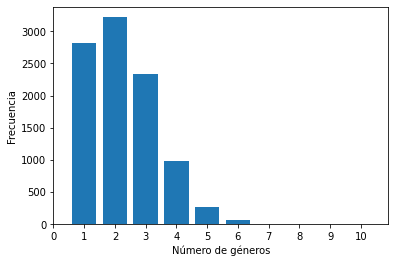

In [13]:
n_genres = Counter(len(r.split('|')) for r in movies['genres'])
plt.bar(n_genres.keys(), n_genres.values())
plt.xlabel(u'Número de géneros')
plt.ylabel(u'Frecuencia')
plt.xticks(range(11))
plt.show()

Examinamos la tabla _links_

In [14]:
links.dropna()
links.sample(5)

,movieId,imdbId,tmdbId
4615,6874,266697,24.0
4375,6408,71143,147729.0
36,40,112749,34615.0
2966,3977,160127,4327.0
8005,97304,1024648,68734.0


In [15]:
#Creamos las vectores de las peliculas
dummies = movies['genres'].str.get_dummies('|')
movies = pd.concat([movies,dummies],axis=1)
movies

,movieId,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
#Guardamos las peliculas con calificacion mayor o igual 4 por el usuario
ratings2 = ratings[ratings['rating'] >= 4.0]

#Creamos el vector para cada usuario con base a las peliculas que le gustaron pero sin normalizar
movies_and_users = ratings2.merge(movies)
movies_and_users['cuenta'] = 1
movies_and_users = movies_and_users.groupby(['userId']).sum().reset_index()[['userId','Action', 'Adventure', 'Animation','Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy','Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance','Sci-Fi', 'Thriller', 'War', 'Western','cuenta']]
movies_and_users

,userId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,cuenta
0,1,76,74,27,37,70,39,0,64,41,...,9,0,20,13,24,32,43,20,6,200
1,2,7,2,0,0,5,6,2,11,0,...,0,2,0,2,1,2,6,1,0,19
2,3,9,4,0,0,1,0,0,1,2,...,8,0,0,1,0,12,6,0,0,16
3,4,13,19,4,7,58,18,1,70,13,...,4,0,12,14,29,5,22,5,7,128
4,5,3,3,5,7,7,7,0,14,5,...,0,1,4,1,3,0,5,2,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,606,57,70,24,23,221,75,4,428,48,...,22,4,24,56,209,37,89,39,6,613
605,607,42,20,2,6,19,16,0,59,8,...,24,1,2,17,13,12,47,4,2,111
606,608,111,62,17,15,78,79,1,127,29,...,33,8,6,31,24,62,113,10,1,280
607,609,1,2,0,0,2,3,0,7,0,...,1,0,0,0,1,0,4,2,1,10


In [17]:
#Normalizamos los vectores con base a los número de peliculas que le gustaron y eliminamos la columna auxiliar
shape = movies_and_users.shape
for j in range(shape[0]):
    for k in range(1,shape[1]):
        movies_and_users.iloc[j,k] = movies_and_users.iloc[j,k]/movies_and_users.iloc[j,-1]

movies_and_users.drop(['cuenta'],axis=1,inplace=True)
movies_and_users

,userId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0.380000,0.370000,0.135000,0.185000,0.350000,0.195000,0.000000,0.320000,0.205000,0.005000,0.045000,0.000000,0.100000,0.065000,0.120000,0.160000,0.215000,0.100000,0.030000
1,2,0.368421,0.105263,0.000000,0.000000,0.263158,0.315789,0.105263,0.578947,0.000000,0.000000,0.000000,0.105263,0.000000,0.105263,0.052632,0.105263,0.315789,0.052632,0.000000
2,3,0.562500,0.250000,0.000000,0.000000,0.062500,0.000000,0.000000,0.062500,0.125000,0.000000,0.500000,0.000000,0.000000,0.062500,0.000000,0.750000,0.375000,0.000000,0.000000
3,4,0.101562,0.148438,0.031250,0.054688,0.453125,0.140625,0.007812,0.546875,0.101562,0.023438,0.031250,0.000000,0.093750,0.109375,0.226562,0.039062,0.171875,0.039062,0.054688
4,5,0.130435,0.130435,0.217391,0.304348,0.304348,0.304348,0.000000,0.608696,0.217391,0.000000,0.000000,0.043478,0.173913,0.043478,0.130435,0.000000,0.217391,0.086957,0.043478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,606,0.092985,0.114192,0.039152,0.037520,0.360522,0.122349,0.006525,0.698206,0.078303,0.008157,0.035889,0.006525,0.039152,0.091354,0.340946,0.060359,0.145188,0.063622,0.009788
605,607,0.378378,0.180180,0.018018,0.054054,0.171171,0.144144,0.000000,0.531532,0.072072,0.000000,0.216216,0.009009,0.018018,0.153153,0.117117,0.108108,0.423423,0.036036,0.018018
606,608,0.396429,0.221429,0.060714,0.053571,0.278571,0.282143,0.003571,0.453571,0.103571,0.007143,0.117857,0.028571,0.021429,0.110714,0.085714,0.221429,0.403571,0.035714,0.003571
607,609,0.100000,0.200000,0.000000,0.000000,0.200000,0.300000,0.000000,0.700000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.100000,0.000000,0.400000,0.200000,0.100000


In [18]:
#Guardamos los id's de los usuarios y sus vectores asociados
y_users = movies_and_users.iloc[:,0].to_numpy(dtype=np.int32)
X_users = movies_and_users.iloc[:,1:].to_numpy(dtype=np.float32)

In [19]:
#Guardamos los id's de las pelicuals y sus vectores asociados
y_movies = movies.iloc[:,0].to_numpy(dtype=np.int32)
X_movies = movies.iloc[:,3:].to_numpy(dtype=np.float32)

In [20]:
#Calculamos las distancias entre los vectores de usuarios y los vectores de las peliculas
distancias = distance_matrix(X_users,X_movies)
distancias

array([[1.80612845, 1.49402141, 1.34614264, ..., 1.05456152, 1.31228807,
        1.02571926],
       [2.25026929, 1.89473684, 1.47274405, ..., 0.80166032, 1.43656253,
        1.12882159],
       [2.34187425, 1.89983552, 1.79843682, ..., 1.49478259, 1.49478259,
        1.49478259],
       ...,
       [2.0973106 , 1.75421868, 1.4511563 , ..., 0.96295543, 1.38569127,
        1.13016954],
       [2.25831796, 1.87082869, 1.51657509, ..., 0.7071068 , 1.64316767,
        1.22474487],
       [2.06378334, 1.74849858, 1.37754787, ..., 0.94053648, 1.39049228,
        1.04081982]])

In [21]:
#Creamos la función de recomendaciones
def recomendacion(usuario,num_recom=3):
    """ 
        La función te indica una cantidad (num_recom) de peliculas recomendadas para el usuario con id (usuario)

        Input:
            usuario: Int, donde el número debe de ser el identificador del usuario
            num: Int, donde el número debe de ser el número de recomendaciones que desea ver
            
        Output:
            recomendaciones_f:List, donde se  entregan los nombres de las recomendaciones de las peliculas que o ha visto el usuario
    """

    #Guardamos el número del renglon asociado en la matriz de distancias al usuario
    indice = np.where(y_users == usuario)[0][0]

    #Guardamos el renglon asociado en la matriz de distancias al usuario
    peliculas = distancias[indice,:]

    #Ordenamos de acuerdo a las distancias (de menor a mayor)
    peliculas_ordenadas = np.argsort(peliculas)

    #Guardamos el ids de las peliculas ya ordenadas por distancia
    ids_peliculas = y_movies[peliculas_ordenadas]
    #print(ids_peliculas)

    #Guardamos las peliculas que ya vio el usuario
    peliculas_vistas = list(ratings[ratings['userId']==usuario].iloc[:,1].values)
    #print(peliculas_vistas)

    #Creamos una lista auxiliar que guardara los ids de las recomendaciones
    recomendaciones_ids = []

    #Llenamos la lista de recomendaciones_ids
    for j in range(ids_peliculas.shape[0]):

        #Checamos que no haya visto la pelicula
        if not(ids_peliculas[j] in peliculas_vistas):
            recomendaciones_ids.append(ids_peliculas[j])

            #Checamos que sea el número de recomendaciones indicado
            if len(recomendaciones_ids) == num_recom:
                break

    #print(recomendaciones_ids)
    
    #Llenamos recomendaciones_f
    recomendaciones_f = []

    #Llenamos con base al titulo
    for j in recomendaciones_ids:
        recomendaciones_f.append(movies[movies['movieId'] == j][['title']].values[0][0])

    print(recomendaciones_f)



In [22]:
recomendacion(500)

['Andrew Dice Clay: Dice Rules (1991)', 'Volunteers (1985)', 'Born Yesterday (1950)']


In [23]:
recomendacion(3)

['Cyborg (1989)', 'Godzilla vs. Mechagodzilla (Gojira tai Mekagojira) (1974)', 'Princess Blade, The (Shura Yukihime) (2001)']


In [24]:
#movies['genres'] = movies['genres'].apply(lambda x : str.split(x,'|'))

#vector_generos = []
#for j in range(movies.shape[0]):
#    for k in movies.iloc[j,-1]:
#        if not (k in vector_generos):
#            vector_generos.append(k)

#for j in vector_generos:
#    movies[j] = 0

#for j in range(movies.shape[0]):
#    for k in movies.iloc[j,2]:
#        indice = vector_generos.index(k) + 3
#        movies.iloc[j,indice] = 1